In [130]:
import pandas as pd
import os
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

In [131]:
data = pd.read_csv('cleaned_football_data.csv')

data

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AvgA,PSCH,PSCD,PSCA,Season,League,LBH,LBD,LBA,HomeWin
0,E0,09/08/2019,Liverpool,Norwich,4,1,H,4.0,0.0,H,...,19.830000,1.14,10.43,19.63,2019,Premier League,2.953658,4.099487,5.155421,1
1,E0,10/08/2019,West Ham,Man City,0,5,A,0.0,1.0,A,...,1.250000,11.11,6.68,1.27,2019,Premier League,2.953658,4.099487,5.155421,0
2,E0,10/08/2019,Bournemouth,Sheffield United,1,1,D,0.0,0.0,D,...,3.830000,1.98,3.67,4.06,2019,Premier League,2.953658,4.099487,5.155421,0
3,E0,10/08/2019,Burnley,Southampton,3,0,H,0.0,0.0,D,...,2.780000,2.71,3.19,2.90,2019,Premier League,2.953658,4.099487,5.155421,1
4,E0,10/08/2019,Crystal Palace,Everton,0,0,D,0.0,0.0,D,...,2.400000,3.37,3.45,2.27,2019,Premier League,2.953658,4.099487,5.155421,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6075,I1,20/05/18,Milan,Fiorentina,5,1,H,2.0,1.0,H,...,4.277143,1.66,4.31,5.23,2017,Serie A,1.800000,3.800000,4.000000,1
6076,I1,20/05/18,Napoli,Crotone,2,1,H,2.0,0.0,H,...,5.790000,1.41,5.55,7.13,2017,Serie A,1.440000,4.600000,6.500000,1
6077,I1,20/05/18,Sassuolo,Roma,0,1,A,0.0,1.0,A,...,1.850000,4.84,3.85,1.78,2017,Serie A,3.800000,3.800000,1.850000,0
6078,I1,20/05/18,Spal,Sampdoria,3,1,H,1.0,0.0,H,...,5.512857,1.85,3.78,4.56,2017,Serie A,1.610000,4.000000,5.200000,1



---

# Regression 2: Predicting **Home Team Goals**

This regression aims to estimate the **expected number of goals scored by the home team**, which is useful for:
- **Team analysis**: Identifying key drivers of offensive performance.
- **Match preparation**: Highlighting factors impacting scoring.

---

### Proposed Model Components:

1. **Likelihood**:
   - The number of goals scored by the home team is **discrete** and non-negative, so we use a **Poisson likelihood**, commonly applied for modeling count data:
     $$
     y_i \sim \text{Poisson}(\lambda_i)
     $$
     where $\lambda_i$ is the expected goals scored by the home team for match $i$.

2. **Predictor**:
   - $\lambda_i$ (the expected home team goals) depends on several predictors:
     - **Home Shots** ($x_{1i}$).
     - **Home Shots on Target** ($x_{2i}$).
     - **Away Shots** ($x_{3i}$).
     - **Away Shots on Target** ($x_{4i}$).
     - **Fouls Committed** (home team $x_{5i}$, away team $x_{6i}$).
   - The linear relationship is modeled as:
     $$
     \log(\lambda_i) = \beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + \beta_3 x_{3i} + \beta_4 x_{4i} + \beta_5 x_{5i} + \beta_6 x_{6i}
     $$
     where:
     - $\beta_0$: Intercept.
     - $\beta_1, \beta_2, \dots, \beta_6$: Coefficients for the predictors.

3. **Priors**:
   - Weakly informative priors are applied to the coefficients:
     $$
     \beta_0, \beta_1, \dots, \beta_6 \sim \mathcal{N}(0, 5)
     $$

---

### Why Is This Useful?

1. **Insights into Offensive Performance**:
   - This model highlights the relationship between different performance indicators and goals scored.

2. **Predictive Power**:
   - It can forecast home team goals, aiding match analysis and planning.

3. **Scalability**:
   - Can be extended to include other predictors (e.g., weather, crowd size).

In [132]:
from sklearn.model_selection import train_test_split

# Selecting relevant columns for the regression
df = data[['FTHG', 'HS', 'HST', 'AS', 'AST', 'HF', 'AF']].dropna()

# Standardizing predictors to improve convergence
df['HS_std'] = (df['HS'] - df['HS'].mean()) / df['HS'].std()
df['HST_std'] = (df['HST'] - df['HST'].mean()) / df['HST'].std()
df['AS_std'] = (df['AS'] - df['AS'].mean()) / df['AS'].std()
df['AST_std'] = (df['AST'] - df['AST'].mean()) / df['AST'].std()
df['HF_std'] = (df['HF'] - df['HF'].mean()) / df['HF'].std()
df['AF_std'] = (df['AF'] - df['AF'].mean()) / df['AF'].std()

# Defining predictors and target variable
X = df[['HS_std', 'HST_std', 'AS_std', 'AST_std', 'HF_std', 'AF_std']].values
y = df['FTHG'].values

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Bayesian Poisson Regression Model
with pm.Model() as model:
    # Priors for coefficients
    beta_0 = pm.Normal('beta_0', mu=0, sigma=5)
    beta_1 = pm.Normal('beta_1', mu=1.5, sigma=0.5)
    beta_2 = pm.Normal('beta_2', mu=2.5, sigma=0.5)
    beta_3 = pm.Normal('beta_3', mu=0, sigma=5)
    beta_4 = pm.Normal('beta_4', mu=0, sigma=5)
    beta_5 = pm.Normal('beta_5', mu=0, sigma=5)
    beta_6 = pm.Normal('beta_6', mu=0, sigma=5)
    
    # Poisson rate parameter
    lambda_ = pm.math.exp(beta_0 + beta_1 * X_train[:, 0] + beta_2 * X_train[:, 1] + 
                          beta_3 * X_train[:, 2] + beta_4 * X_train[:, 3] + 
                          beta_5 * X_train[:, 4] + beta_6 * X_train[:, 5])
    
    # Likelihood (Poisson)
    y_obs = pm.Poisson('y_obs', mu=lambda_, observed=y_train)
    
    # Sampling
    trace = pm.sample(2000, tune=1000, return_inferencedata=True, target_accept=0.95)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2, beta_3, beta_4, beta_5, beta_6]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 27 seconds.


array([[<Axes: title={'center': 'beta_0'}>,
        <Axes: title={'center': 'beta_0'}>],
       [<Axes: title={'center': 'beta_1'}>,
        <Axes: title={'center': 'beta_1'}>],
       [<Axes: title={'center': 'beta_2'}>,
        <Axes: title={'center': 'beta_2'}>],
       [<Axes: title={'center': 'beta_3'}>,
        <Axes: title={'center': 'beta_3'}>],
       [<Axes: title={'center': 'beta_4'}>,
        <Axes: title={'center': 'beta_4'}>],
       [<Axes: title={'center': 'beta_5'}>,
        <Axes: title={'center': 'beta_5'}>],
       [<Axes: title={'center': 'beta_6'}>,
        <Axes: title={'center': 'beta_6'}>]], dtype=object)

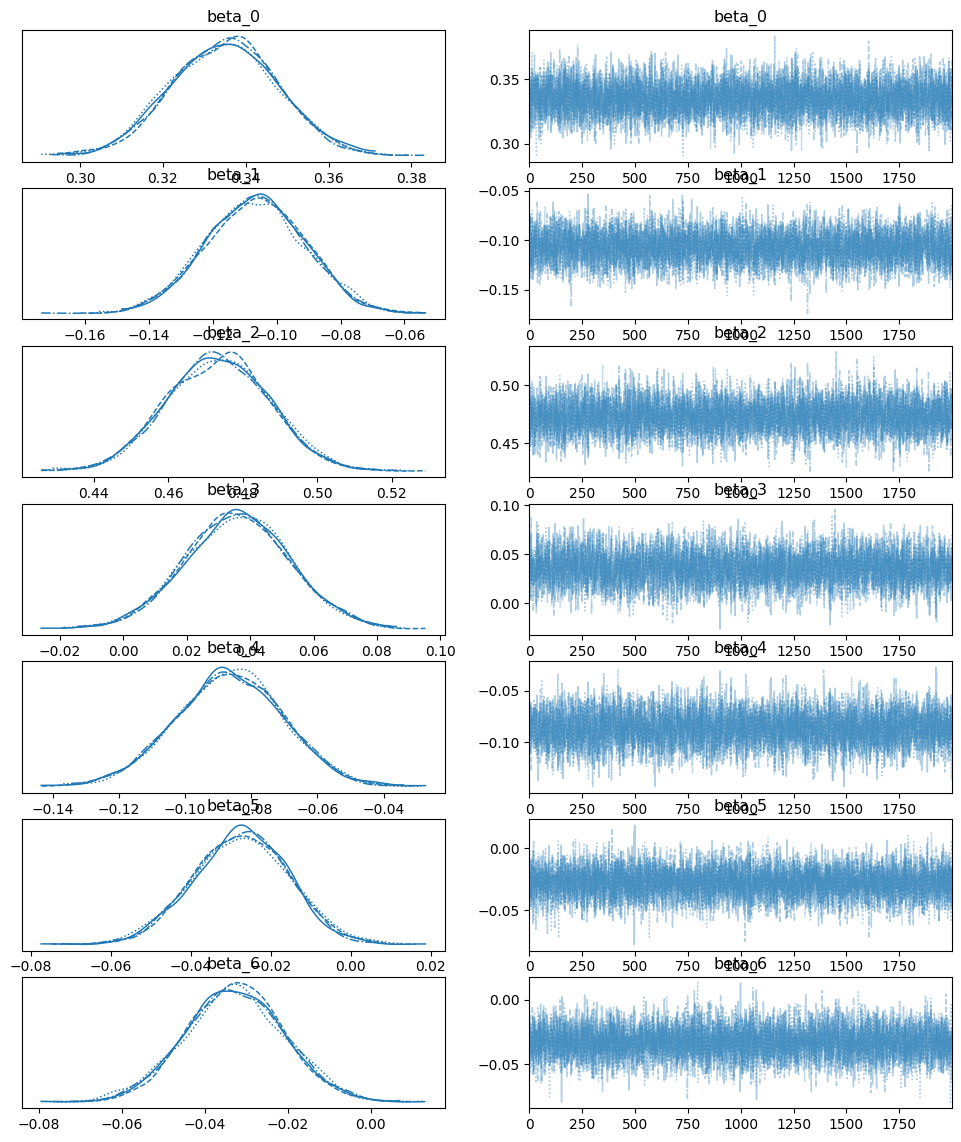

In [133]:
# Plot the trace
az.plot_trace(trace)

array([[<Axes: title={'center': 'beta_0'}>,
        <Axes: title={'center': 'beta_1'}>,
        <Axes: title={'center': 'beta_2'}>],
       [<Axes: title={'center': 'beta_3'}>,
        <Axes: title={'center': 'beta_4'}>,
        <Axes: title={'center': 'beta_5'}>],
       [<Axes: title={'center': 'beta_6'}>, <Axes: >, <Axes: >]],
      dtype=object)

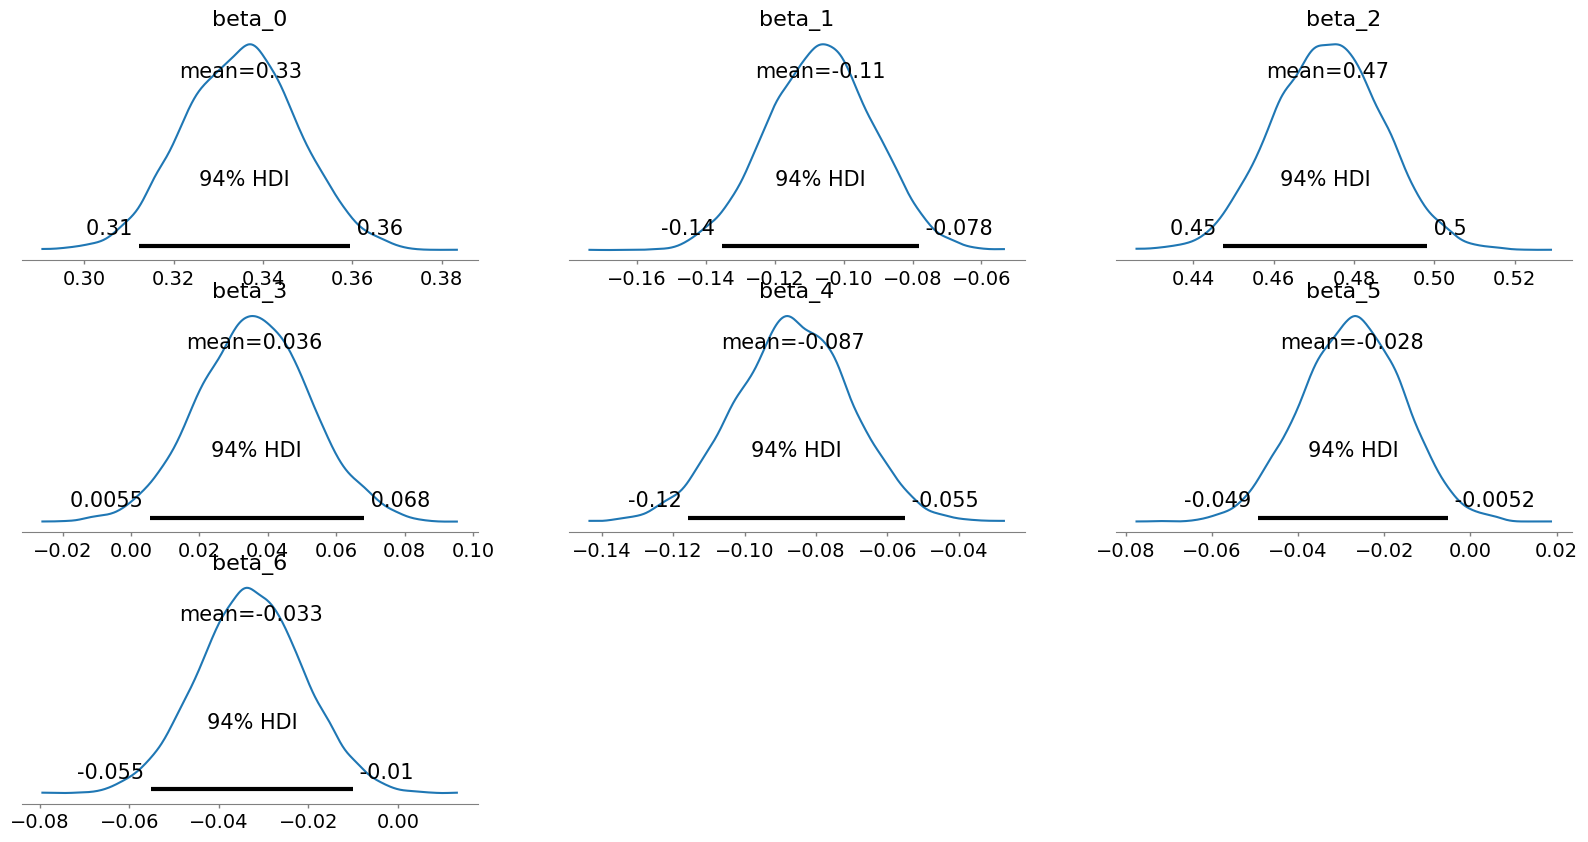

In [134]:
# Plot the posterior distributions with custom dimensions
az.plot_posterior(trace, figsize=(20, 10))

In [135]:
# Display the trace summary
trace_summary = pm.summary(trace)
trace_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,0.335,0.013,0.312,0.359,0.0,0.0,7503.0,5848.0,1.0
beta_1,-0.107,0.015,-0.135,-0.078,0.0,0.0,6367.0,6166.0,1.0
beta_2,0.473,0.014,0.447,0.498,0.0,0.0,6132.0,6049.0,1.0
beta_3,0.036,0.016,0.006,0.068,0.0,0.0,5122.0,5733.0,1.0
beta_4,-0.087,0.016,-0.116,-0.055,0.0,0.0,5626.0,5527.0,1.0
beta_5,-0.028,0.012,-0.049,-0.005,0.0,0.0,7991.0,6245.0,1.0
beta_6,-0.033,0.012,-0.055,-0.010,0.0,0.0,7667.0,6186.0,1.0


## Posterior Predictive Checks

Posterior Predictive Checks (PPCs) allow us to assess how well the model reproduces the observed data. These checks compare the observed data against data simulated from the posterior predictive distribution.

---

### 1. Histogram of Observed vs Predicted Values
- This plot overlays the observed data with the predicted data to check for overall agreement.
- A high degree of overlap suggests the model captures the data well.

---

Sampling: [y_obs]


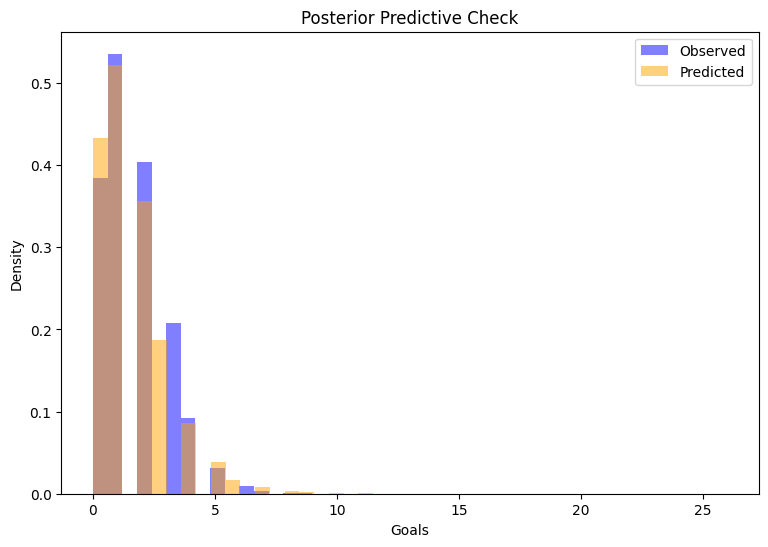

In [163]:
# Posterior predictive check
with model:
    ppc = pm.sample_posterior_predictive(trace, random_seed=42)

# Directly access observed data and posterior predictive samples
observed_data = ppc["observed_data"]["y_obs"].values  # Extract numpy array
posterior_predictive_samples = ppc["posterior_predictive"]["y_obs"].values  # Extract numpy array

# Plot observed vs predicted
plt.figure(figsize=(9, 6))
plt.hist(observed_data, bins=15, alpha=0.5, label="Observed", color="blue", density=True)
plt.hist(
    posterior_predictive_samples.ravel(),  # Use ravel for flattening
    bins=43,
    alpha=0.5,
    label="Predicted",
    color="orange",
    density=True,
)
plt.legend()
plt.title("Posterior Predictive Check")
plt.xlabel("Goals")
plt.ylabel("Density")
plt.show()

<Axes: xlabel='y_obs'>

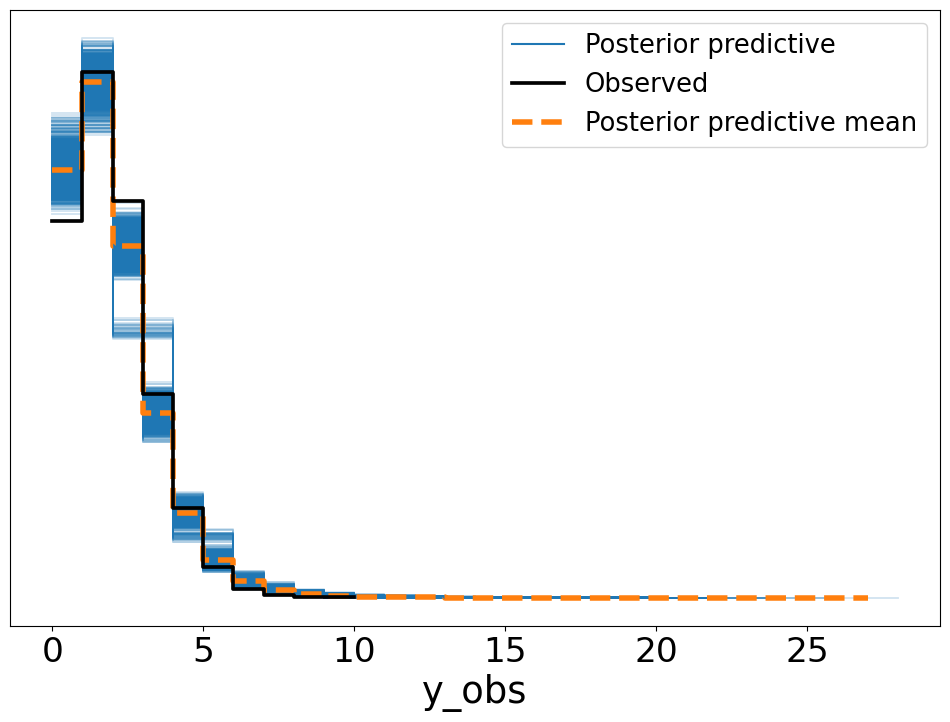

In [158]:
az.plot_ppc(ppc,figsize=(12, 8))

#### Interpretation of Posterior Predictive Check (Histogram)

1. **Overall Agreement**:
   - The predicted distribution (orange) aligns quite well with the observed data (blue), this suggests the model captures the general trend in the observed data.

2. **Peak Alignment**:
   - The peaks of the observed and predicted distributions are close, indicating that the model is estimating the most frequent outcomes correctly.

3. **Discrepancies at Higher Values**:
   - For goals greater than 5, the predicted distribution becomes sparse and slightly overestimates the frequency compared to the observed data.
   - This could indicate that the model struggles with rare, high-scoring matches.

4. **Skewness**:
   - Both distributions are heavily skewed toward lower goal counts, which is expected in football data. The model captures this skewness effectively.
---


### 2. Overlay of Observed vs Predicted for Each Observation
- We plot the actual observed values against the predicted means for each observation:
  $$
  \hat{y}_i = \text{mean of posterior predictive samples for observation } i
  $$
- This helps identify systematic over- or under-prediction.


In [138]:
# Reshape posterior predictive samples to combine chains and samples
posterior_predictive_samples_flat = posterior_predictive_samples.reshape(-1, posterior_predictive_samples.shape[2])

# Calculate predicted means
predicted_means = posterior_predictive_samples_flat.mean(axis=0)


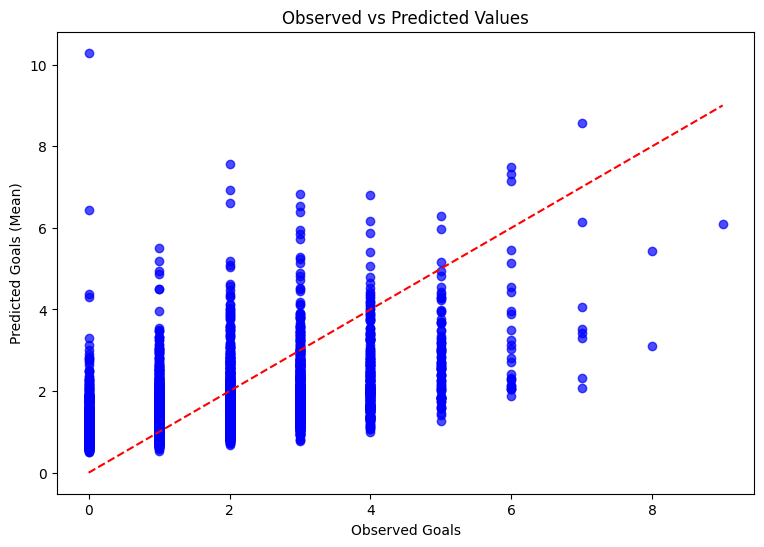

In [167]:
plt.figure(figsize=(9, 6))
plt.scatter(observed_data, predicted_means, alpha=0.7, color="blue")
plt.plot([0, max(observed_data)], [0, max(observed_data)], linestyle="--", color="red")
plt.title("Observed vs Predicted Values")
plt.xlabel("Observed Goals")
plt.ylabel("Predicted Goals (Mean)")
plt.show()

#### Interpretation of Observed vs. Predicted Values Plot

1. **Alignment with the Diagonal**:
   - The red dashed line represents perfect agreement between observed and predicted values.
   - Most points cluster near the diagonal, indicating that the model predicts goals reasonably well on average.

2. **Spread Around the Diagonal**:
   - There is noticeable spread around the diagonal, especially for higher observed goal counts. This suggests that the model's uncertainty increases for matches with more goals.
   - For lower goal counts (0 to 3), the predictions are tighter and closer to the diagonal.

3. **Over- and Under-Predictions**:
   - **Under-predictions**: Observed goals of 6 or more often have predicted means lower than the observed values.
   - **Over-predictions**: Some points with low observed goals (e.g., 0, 1 or 2) have predicted means higher than observed.

4. **Model Limitations**:
   - The spread and underestimation of higher goal counts might indicate that the predictors used are not fully capturing the factors driving high-scoring games.

#### Conclusion:
The model performs well for common outcomes (0 to 3 goals) but shows limitations in predicting higher-scoring games. This aligns with the findings from the histogram. Improving the model might involve:
- Adding more features (e.g., team strength, recent form).
- Considering a hierarchical model to capture variability across different teams or leagues.

---



### 3. Predictive Distributions for Individual Observations
- For selected observations, we can plot the entire posterior predictive distribution to understand the variability in predictions.



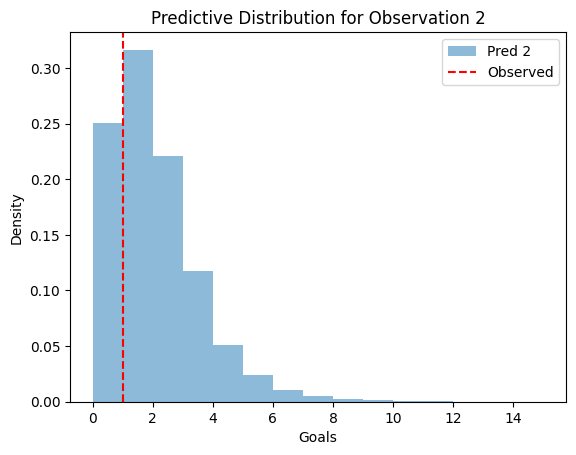

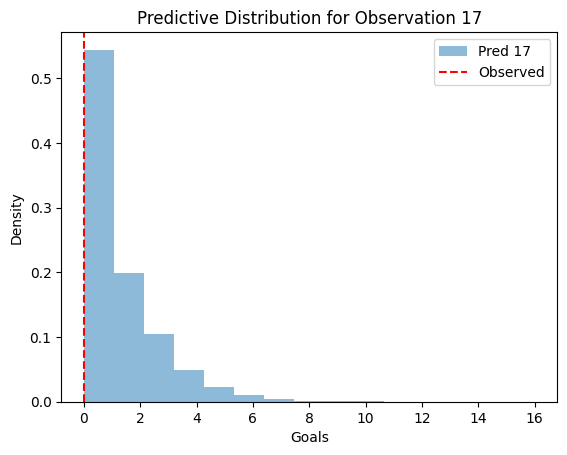

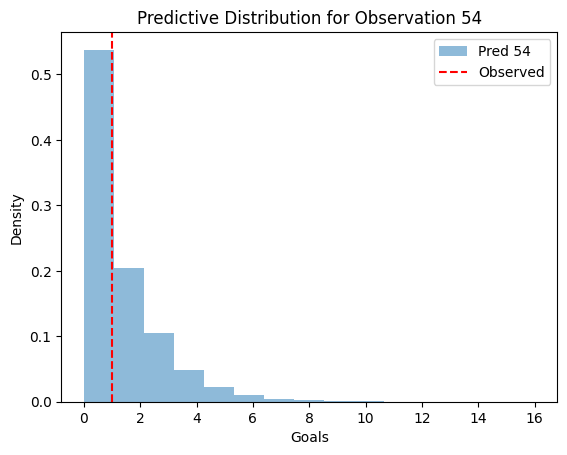

In [172]:
# 3. Predictive Distributions for Individual Observations
obs_index = [2, 17, 54]  # Example indices for observations
for idx in obs_index:
    plt.hist(posterior_predictive_samples[:, idx].flatten(), bins=15, alpha=0.5, label=f"Pred {idx}", density=True)
    plt.axvline(observed_data[idx], color="red", linestyle="--", label="Observed")
    plt.legend()
    plt.title(f"Predictive Distribution for Observation {idx}")
    plt.xlabel("Goals")
    plt.ylabel("Density")
    plt.show()


### 4. Predictive Distributions for Individual Observations for Test Data
- For selected observations, we can plot the entire posterior predictive distribution to understand the variability in predictions regarding the test data.



Sampling: [y_test_pred]


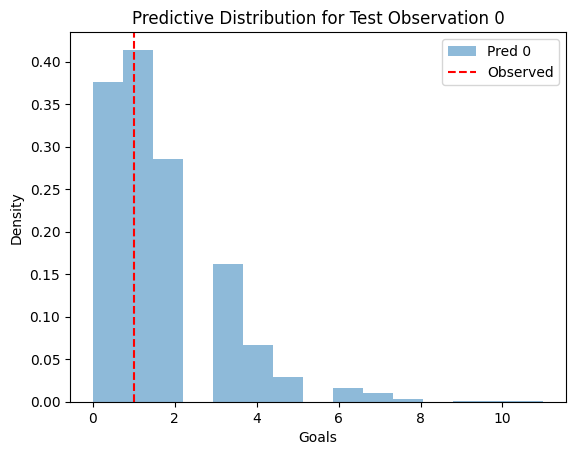

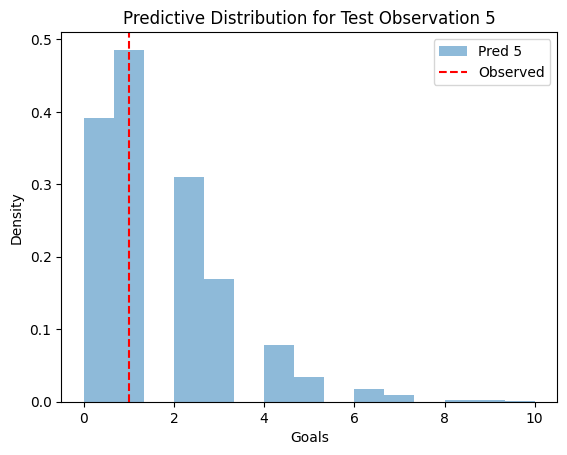

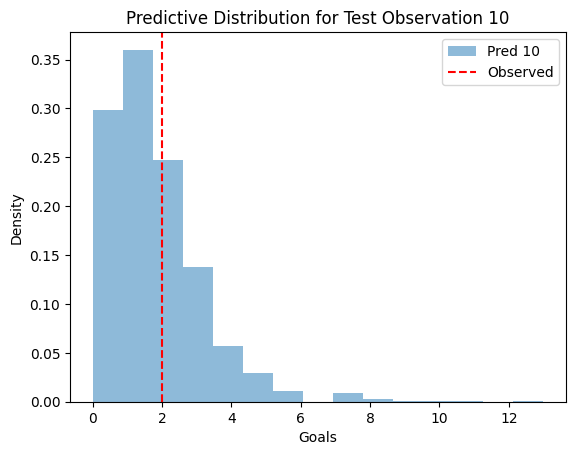

In [141]:
# Generate predictions for the test set
with model:
    # Define a new likelihood for the test set
    lambda_test = pm.math.exp(beta_0 + beta_1 * X_test[:, 0] + beta_2 * X_test[:, 1] + 
                      beta_3 * X_test[:, 2] + beta_4 * X_test[:, 3] + 
                      beta_5 * X_test[:, 4] + beta_6 * X_test[:, 5])
    y_test_pred = pm.Poisson("y_test_pred", mu=lambda_test, shape=X_test.shape[0])
    
    # Posterior predictive sampling for the test set
    ppc_test = pm.sample_posterior_predictive(trace, var_names=["y_test_pred"], random_seed=42)

# Access posterior predictive samples for the test set
posterior_predictive_test_samples = ppc_test["posterior_predictive"]["y_test_pred"].values

# Observed test data
observed_test_data = y_test

# Predictive Distributions for Individual Observations in the Test Set
obs_index = [0, 5, 10]  # Example indices for test observations

for idx in obs_index:
    plt.hist(posterior_predictive_test_samples[:, idx].flatten(), bins=15, alpha=0.5, label=f"Pred {idx}", density=True)
    plt.axvline(observed_test_data[idx], color="red", linestyle="--", label="Observed")
    plt.legend()
    plt.title(f"Predictive Distribution for Test Observation {idx}")
    plt.xlabel("Goals")
    plt.ylabel("Density")
    plt.show()


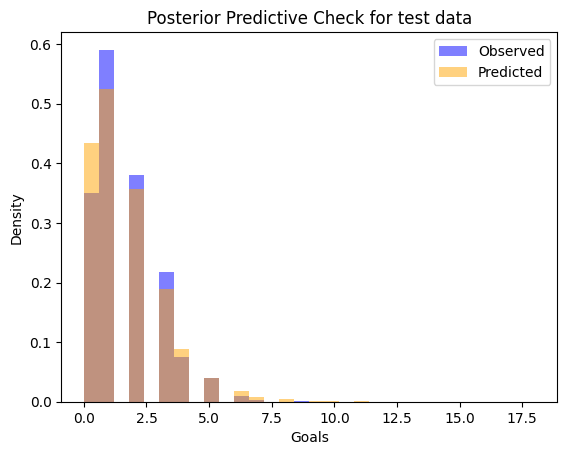

In [145]:
# Plot observed vs predicted for test
plt.hist(observed_test_data, bins=15, alpha=0.5, label="Observed", color="blue", density=True)
plt.hist(
    posterior_predictive_test_samples.ravel(),  # Use ravel for flattening
    bins=30,
    alpha=0.5,
    label="Predicted",
    color="orange",
    density=True,
)
plt.legend()
plt.title("Posterior Predictive Check for test data")
plt.xlabel("Goals")
plt.ylabel("Density")
plt.show()


---
### 5. Test Statistic Comparison
- A test statistic \( T(y) \) (e.g., mean, variance) is computed for the observed data and compared to its distribution under the posterior predictive samples.

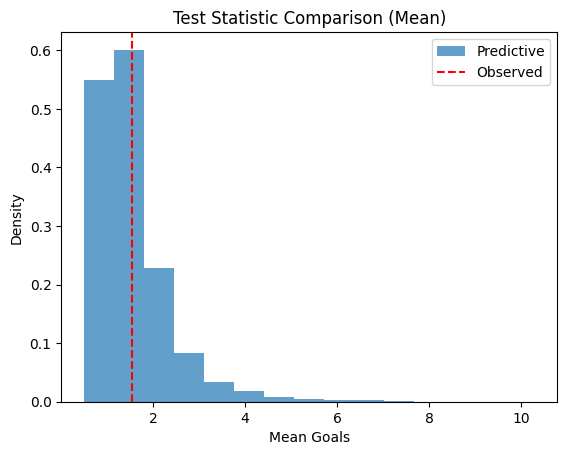

In [151]:
# 3. Test Statistic Comparison
test_stat_observed = observed_data.mean()
test_stat_predictive = predicted_means

plt.hist(test_stat_predictive, bins=15, alpha=0.7, label="Predictive", density=True)
plt.axvline(test_stat_observed, color="red", linestyle="--", label="Observed")
plt.legend()
plt.title("Test Statistic Comparison (Mean)")
plt.xlabel("Mean Goals")
plt.ylabel("Density")
plt.show()

#### Interpretation of Test Statistic Comparison (Mean)

1. **Predictive Distribution of the Mean**:
   - The histogram represents the distribution of the predicted mean goals across the posterior predictive samples. It is centered around approximately **2 goals**, which matches the general trend in the observed data.

2. **Observed Mean**:
   - The red dashed line indicates the observed mean of the dataset. It aligns well with the center of the predictive distribution, indicating that the model captures the overall average goal count accurately.

3. **Spread of Predictive Samples**:
   - The spread of the predictive distribution reflects the model's uncertainty in estimating the mean goal count. The majority of the density is concentrated near the observed mean, suggesting that the model is robust in predicting the mean goals.

4. **High-Scoring Games**:
   - There is a small tail for high mean goal counts (>4), which is consistent with the model's underperformance in predicting rare, high-scoring games, as observed in previous plots.

#### Conclusion:
The model captures the observed mean goals accurately, as evidenced by the alignment of the predictive and observed means. However, the slight tail for higher values indicates that the model may not fully account for variability in extreme cases. This could be mitigated by adding more predictors or considering hierarchical modeling.

---


### 6. Residual Analysis
- Residuals are defined as:
  $$
  r_i = y_i - \hat{y}_i
  $$
- Analyzing residuals helps identify patterns or outliers that the model may not capture.

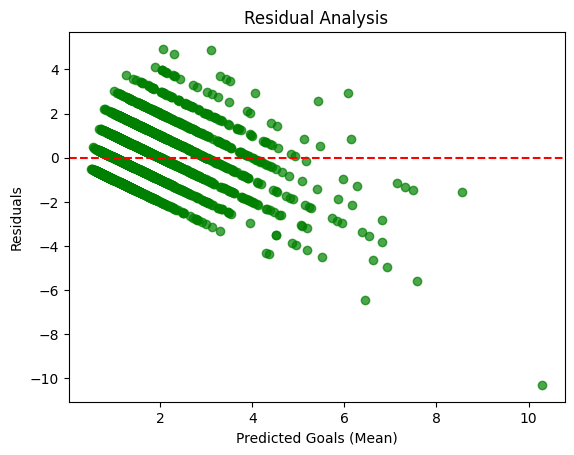

In [152]:
# 4. Residual Analysis
residuals = observed_data - predicted_means
plt.scatter(predicted_means, residuals, alpha=0.7, color="green")
plt.axhline(0, linestyle="--", color="red")
plt.title("Residual Analysis")
plt.xlabel("Predicted Goals (Mean)")
plt.ylabel("Residuals")
plt.show()

#### 1. **Pattern in Residuals**:
- **Observation**: The residuals show a clear downward trend as predicted values increase.
- **Implication**: This pattern suggests a **systematic bias** in the model. The model consistently **over-predicts lower values** (residuals > 0) and **under-predicts higher values** (residuals < 0).
- **Cause**: This could be due to the **Poisson likelihood**, which assumes that the variance is equal to the mean. This assumption may not hold if the data exhibits **over-dispersion** (variance > mean).



#### 2. **Clustering**:
- **Observation**: Residuals are tightly clustered for lower predicted values (e.g., around 2-4), but they spread out for larger predicted values.
- **Implication**: The model performs better for lower predicted values but struggles to capture variability as predictions increase. This may indicate that the model struggles with higher goal counts, potentially due to insufficient predictors or the limitations of the Poisson distribution.


#### 3. **Extreme Residuals**:
- **Observation**: A few residuals are as low as -10 (far below the red horizontal line).
- **Implication**: These extreme residuals are likely outliers where the model failed to capture the observed values entirely.
